In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [24]:
LOOKAHEAD = 7
SPLIT_DATE = "2015-01-01"

In [25]:
COLS_TO_DROP_TIME = ['date', 'season_num', 'year', 'month', 'day', 'week', 'weekday', 'dayofyear', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos']

TARGET_COLS_7D = [
    't2m_d1_forecast', 't2m_d2_forecast', 't2m_d3_forecast', 't2m_d4_forecast', 
    't2m_d5_forecast', 't2m_d6_forecast', 't2m_d7_forecast'
]

In [26]:
FILE_PATH = "../Dataset/FeatureEngineering_T2M_data.csv" 
df = pd.read_csv(FILE_PATH, parse_dates=["date"])
df = df.sort_values("date").copy()

print(f"Loaded new dataset with shape: {df.shape}")

Loaded new dataset with shape: (16378, 342)


In [27]:
COLS_TO_DROP_FINAL = COLS_TO_DROP_TIME + TARGET_COLS_7D 
X = df.drop(columns=COLS_TO_DROP_FINAL, errors='ignore').copy()
Y = df[TARGET_COLS_7D].copy()

In [28]:
valid_indices = X.dropna().index
X = X.loc[valid_indices].copy()
Y = Y.loc[valid_indices].copy()

In [29]:
split_date = pd.to_datetime(SPLIT_DATE)

df_split = df.loc[valid_indices]

In [30]:
X_train = X[df_split['date'] < split_date]
X_test = X[df_split['date'] >= split_date]
y_train = Y[df_split['date'] < split_date]
y_test = Y[df_split['date'] >= split_date]

test_dates = df_split[df_split['date'] >= split_date]['date']

print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

X shape: (16378, 328), Y shape: (16378, 7)
Train size: (12411, 328), Test size: (3967, 328)


In [ ]:
rf_params = {
    "n_estimators": 500,      
    "max_depth": 10,          
    "random_state": 42,
    "n_jobs": -1
}

In [32]:
model = MultiOutputRegressor(RandomForestRegressor(**rf_params))

print("\nStart training Random Forest Multi-Output Model...")
model.fit(X_train, y_train)
print("Random Forest Training Complete.")

preds = model.predict(X_test)


Start training Random Forest Multi-Output Model...
Random Forest Training Complete.


In [33]:
rmse_scores = []
for i in range(LOOKAHEAD):
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], preds[:, i]))
    rmse_scores.append(rmse)
    print(f"{Y.columns[i]} RMSE: {rmse:.4f}") 

print(f"\nAverage RMSE across {LOOKAHEAD} days: {np.mean(rmse_scores):.4f}")

t2m_d1_forecast RMSE: 0.6852
t2m_d2_forecast RMSE: 0.9584
t2m_d3_forecast RMSE: 1.0858
t2m_d4_forecast RMSE: 1.1513
t2m_d5_forecast RMSE: 1.1925
t2m_d6_forecast RMSE: 1.2075
t2m_d7_forecast RMSE: 1.2202

Average RMSE across 7 days: 1.0715


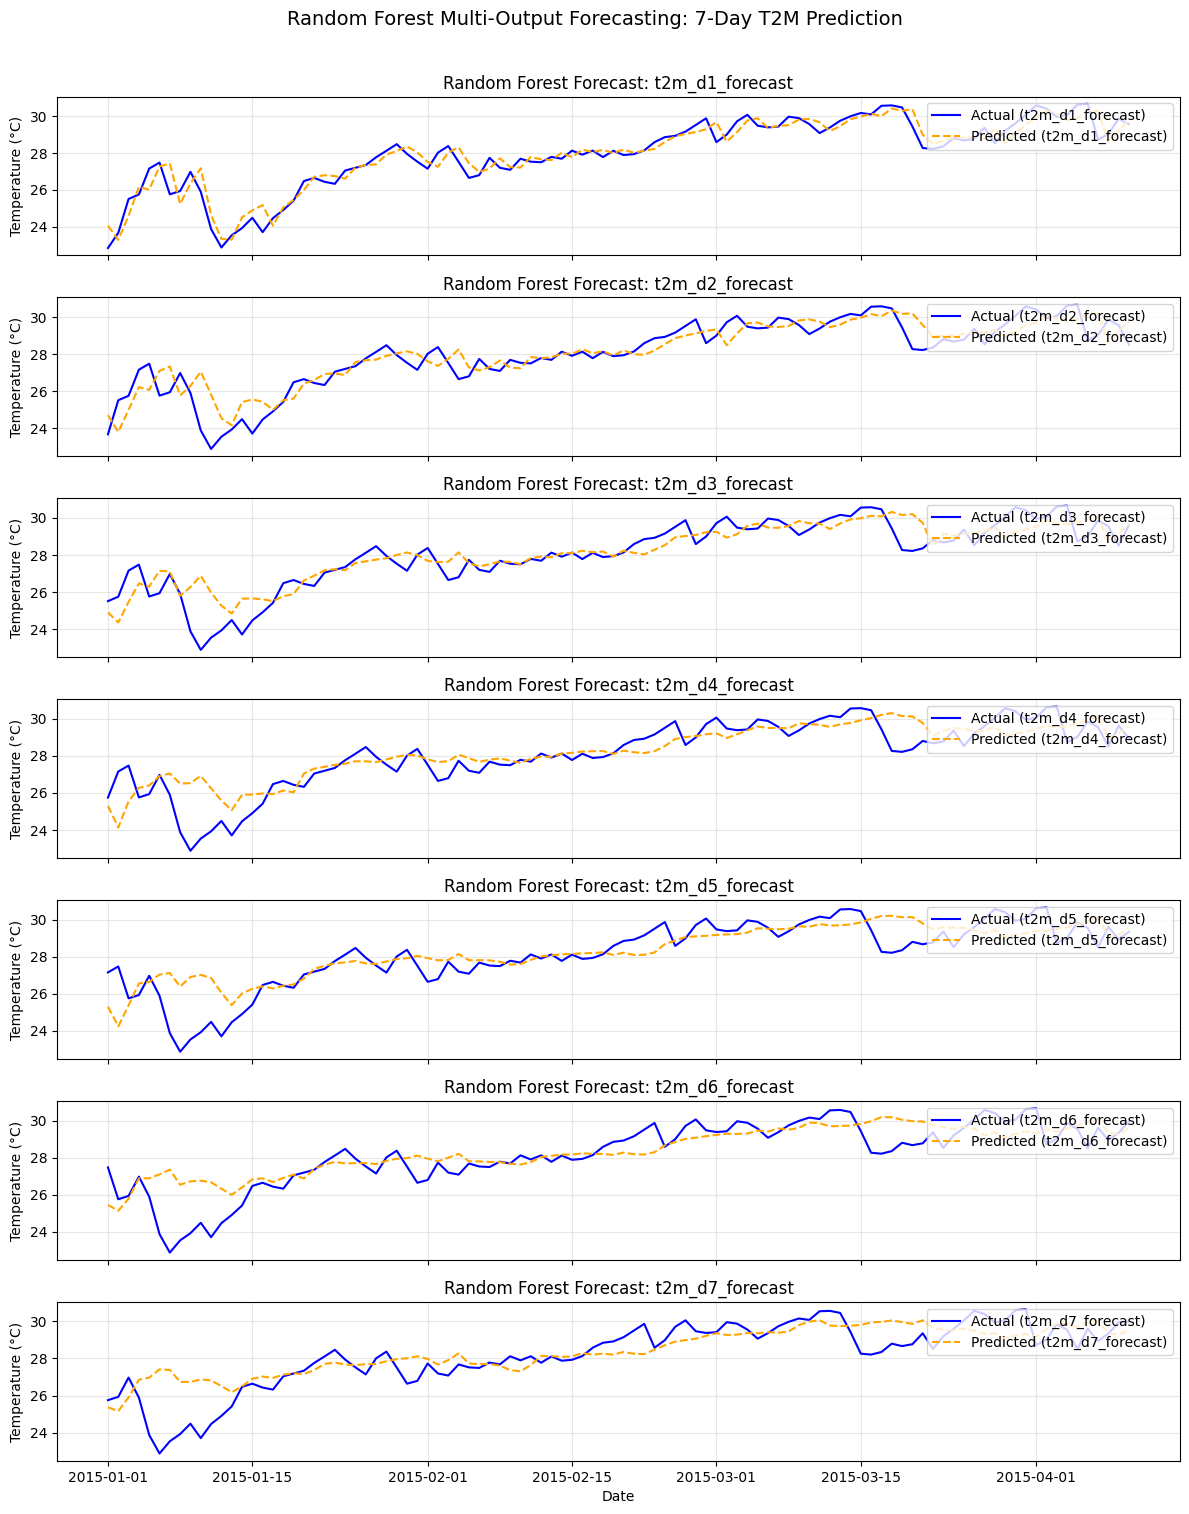

In [34]:
fig, axes = plt.subplots(LOOKAHEAD, 1, figsize=(12, 2.2 * LOOKAHEAD), sharex=True)
sample_size = 100

for i in range(LOOKAHEAD):
    axes[i].plot(test_dates.iloc[:sample_size], y_test.iloc[:sample_size, i].values, label=f"Actual ({TARGET_COLS_7D[i]})", color='blue')
    axes[i].plot(test_dates.iloc[:sample_size], preds[:sample_size, i], linestyle="--", label=f"Predicted ({TARGET_COLS_7D[i]})", color='orange')
    
    axes[i].set_title(f"Random Forest Forecast: {TARGET_COLS_7D[i]}")
    axes[i].set_ylabel("Temperature (°C)")
    axes[i].legend(loc="upper right")
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel("Date")
plt.suptitle("Random Forest Multi-Output Forecasting: 7-Day T2M Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()